## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> The output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> The goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [84]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Helper Functions

These are some helper functions to perform the lane detection

In [104]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lines = []
    right_lines = []
    left_slopes = []
    right_slopes = []
    left_intercepts = []
    right_intercepts = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            # 1) Separate line segments by slope
            if slope > 0:
                right_lines.append(line)
                right_slopes.append(slope)
                right_intercepts.append(y1-slope*x1)
            else:
                left_lines.append(line)
                left_slopes.append(slope)
                left_intercepts.append(y1-slope*x1)
    # 2) Average line position and extrapolation.
    #460, 310
    m_left=np.mean(left_slopes)
    b_left=np.mean(left_intercepts)
    y1_left=img.shape[0]
    x1_left=np.int32((y1_left-b_left)/m_left)
    x2_left=np.int32(img.shape[1]/2)-15
    y2_left=np.int32(m_left*x2_left+b_left)
    cv2.line(img, (x1_left, y1_left), (x2_left, y2_left), color, thickness)   
   
    m_right=np.mean(right_slopes)
    b_right=np.mean(right_intercepts)
    y1_right=img.shape[0]
    x1_right=np.int32((y1_right-b_right)/m_right)
    x2_right=np.int32(img.shape[1]/2)+15
    y2_right=np.int32(m_right*x2_right+b_right)
    cv2.line(img, (x1_right, y1_right), (x2_right, y2_right), color, thickness)   

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img
 
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.   based on guess and looking which was the output :p      
def process_image(image):

    gray = grayscale(image)

    # Apply Gaussian smoothing
    blur_gray = gaussian_blur(image, kernel_size = 15)

    # Apply Canny in order to perform the edge detection
    edges = canny(blur_gray, low_threshold = 50, high_threshold = 100)

    #image size: 960x540
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(460, 310), (460, 310), (imshape[1],imshape[0])]], dtype=np.int32) 
    masked_edges=region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 25 #minimum number of pixels making up a line
    max_line_gap = 75    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image) # creating a blank to draw lines on
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    #color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    #lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

    # Save the image
    return line_image
    
def process_image_pipeline(image):

    gray = grayscale(image)

    # Apply Gaussian smoothing
    blur_gray = gaussian_blur(image, kernel_size = 15)

    # Apply Canny in order to perform the edge detection
    edges = canny(blur_gray, low_threshold = 50, high_threshold = 100)

    #image size: 960x540
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(460, 310), (460, 310), (imshape[1],imshape[0])]], dtype=np.int32) 
    masked_edges=region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 25 #minimum number of pixels making up a line
    max_line_gap = 75    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image) # creating a blank to draw lines on
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    # Define the Hough transform parameters
    lines =  hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(lines, 0.8, line_image, 1, 0) 
    plt.imshow(lines_edges)
    return lines_edges
 

Exception ignored in: <bound method VideoFileClip.__del__ of <moviepy.video.io.VideoFileClip.VideoFileClip object at 0x000000A61935F320>>
Traceback (most recent call last):
  File "C:\Users\LPC\Miniconda3\envs\carnd-term1\lib\site-packages\moviepy\video\io\VideoFileClip.py", line 90, in __del__
    del self.reader
AttributeError: reader


## Main function



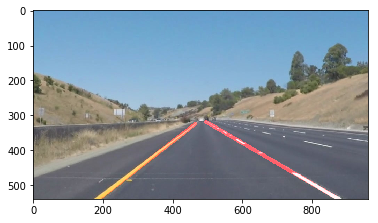

In [99]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

from helper import *
testOnline=True # true=save the files in your computer

def process_videos():
    #Function that performs the video lane Detection 
    #video processing (ref: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_video_display/py_video_display.html)
    output_dir="video_output/"
    input_dir="test_video"
    create_directory("video_output")
    fourcc = cv2.VideoWriter_fourcc(*'XVID')

    for video_name in os.listdir(input_dir):
        cap = cv2.VideoCapture(input_dir+"/"+video_name)
        out = cv2.VideoWriter(output_dir+video_name,fourcc, 20.0, (960,540)) 
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret==True:
                image_line = process_image_pipeline(frame)
                out.write(image_line)
            else:
                break
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        
def process_images():
    #Function that performs the image lane Detection 
    output_dir="image_output/"
    input_dir="test_images"
    create_directory("image_output")

    for image_name in os.listdir(input_dir):
        image = mpimg.imread(input_dir+"/"+image_name)
        image_line = process_image(image)
        if testOnline==True:
            cv2.imwrite(output_dir+image_name, cv2.cvtColor(image_line, cv2.COLOR_RGB2BGR))
        
def process_images_pipeline():
    #Function that performs the image pipeline lane Detection
    output_dir="image_output_pipeline/"
    input_dir="test_images"
    create_directory("image_output_pipeline")

    for image_name in os.listdir(input_dir):
        image = mpimg.imread(input_dir+"/"+image_name)
        image_line = process_image_pipeline(image) 
        if testOnline==True:
            cv2.imwrite(output_dir+image_name, cv2.cvtColor(image_line, cv2.COLOR_RGB2BGR))
            plt.imshow(image_line)

#Image + Video lane detection
#process_images() # lane detection
process_images_pipeline() # image lane detection pipeline
#process_videos() # video lane detection pipeline


## Test on Videos (jupyter)

In [100]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [101]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

OSError: [WinError 6] Controlador no válido

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [102]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [103]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

OSError: [WinError 6] Controlador no válido

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))